In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

restaurants = pd.read_csv('final_restaurants.csv')
restaurants

,Unnamed: 0,lat,lon,amenity,name,tags,address,Code,Place,is chain
0,0,49.260812,-123.125736,cafe,starbucks,"{'brand:wikidata': 'Q37158', 'official_name': ...","1001 W 12th Ave, Vancouver, BC V6H 0A5, Canada",V6H,Vancouver (West Fairview / Granville Island / ...,True
1,2,49.263582,-123.128836,cafe,waves,{'opening_hours': 'Mo-Fr 06:00-24:00; Sa-Su 08...,"1095 BC-7, Vancouver, BC V6H 0A8, Canada",V6H,Vancouver (West Fairview / Granville Island / ...,True
2,7,49.263448,-123.138067,fast_food,mcdonald's,"{'brand:wikidata': 'Q38076', 'addr:housenumber...","1482 BC-7, Vancouver, BC V6H 4E8, Canada",V6H,Vancouver (West Fairview / Granville Island / ...,True
3,9,49.263225,-123.133390,restaurant,denny's,"{'brand:wikidata': 'Q1189695', 'addr:housenumb...","1296 W Broadway, Vancouver, BC V6H 1G6, Canada",V6H,Vancouver (West Fairview / Granville Island / ...,True
4,10,49.271156,-123.135808,restaurant,the keg,"{'brand:wikidata': 'Q7744066', 'wheelchair': '...","1499 Duranleau St, Vancouver, BC V6H 3S3, Canada",V6H,Vancouver (West Fairview / Granville Island / ...,True
...,...,...,...,...,...,...,...,...,...,...
5096,5092,49.033067,-123.069255,restaurant,browns socialhouse,{},"1665 56 St, Delta, BC V4L 2B2, Canada",V4L,Delta Southeast,False
5097,5095,49.024524,-123.066485,cafe,wood n frog coffee company,{},"5694 12 Ave, Delta, BC V4L 1C4, Canada",V4L,Delta Southeast,False
5098,5097,49.250815,-123.168022,fast_food,ridge garden,"{'addr:housenumber': '4009', 'phone': '+1-604-...","4017 Macdonald St, Vancouver, BC V6L 2N8, Canada",V6L,Vancouver (NW Arbutus Ridge),False
5099,5098,49.187647,-122.552271,cafe,kanaka creek coffee,{},"24155 102 Ave, Maple Ridge, BC V2W 2C6, Canada",V2W,Maple Ridge East,False


## Chi-squared test

In [2]:
contingency = list()
for code in restaurants['Code'].unique():
    chains = restaurants[restaurants['Code']==code]['is chain'].sum()
    indie = restaurants[restaurants['Code']==code]['is chain'].count() - chains
    if chains != 0 and indie != 0:
        contingency.append([indie, chains])
chi2res = stats.chi2_contingency(contingency)
chi2res[1]
# extremely small p-value, reject that values are independent across categories.

1.4259027842371983e-38

## Predicting price_level with RF

In [3]:
prices = pd.read_csv('hot_encoded_rests.csv')
prices = prices[['name','lat','lon','code','price_level','rating','user_ratings_total','bar', 'bistro',
       'cafe', 'fast_food', 'ice_cream', 'juice_bar', 'pub', 'restaurant','chain_False','chain_True']]
prices.loc[prices['price_level'].isnull(), ['price_level']] = 0 # Make NaN price levels zero.
prices

,name,lat,lon,code,price_level,rating,user_ratings_total,bar,bistro,cafe,fast_food,ice_cream,juice_bar,pub,restaurant,chain_False,chain_True
0,starbucks,49.260812,-123.125736,V6H,2.0,3.9,127,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,waves,49.263582,-123.128836,V6H,0.0,3.8,290,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,mcdonald's,49.263448,-123.138067,V6H,1.0,3.4,539,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,denny's,49.263225,-123.133390,V6H,2.0,4.0,532,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4,the keg,49.271156,-123.135808,V6H,3.0,4.2,1366,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5096,browns socialhouse,49.033067,-123.069255,V4L,2.0,4.0,348,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
5097,wood n frog coffee company,49.024524,-123.066485,V4L,1.0,4.6,224,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
5098,ridge garden,49.250815,-123.168022,V6L,2.0,4.1,79,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
5099,kanaka creek coffee,49.187647,-122.552271,V2W,2.0,4.7,261,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


<ipython-input-16-78c9836c7597>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_count['num'] = 1


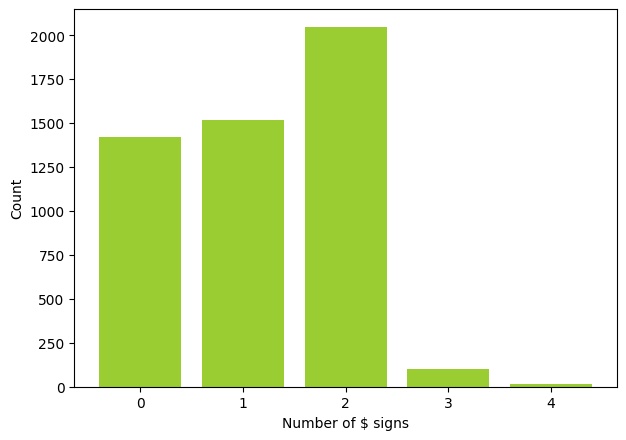

In [16]:
plt.figure(figsize=(7, 5), dpi=100)
price_count = prices[['price_level']]
price_count['num'] = 1
price_count = price_count.groupby('price_level').agg('count').reset_index()
plt.bar(price_count['price_level'], price_count['num'], color='yellowgreen')
plt.xlabel('Number of $ signs')
plt.ylabel('Count')
plt.show()

In [6]:
X = prices.drop(['name','code','price_level','price_group'], axis=1).to_numpy()
y = prices['price_level']
X_train, X_valid, y_train, y_valid = train_test_split(X, y)

In [7]:
model = RandomForestClassifier(n_estimators=1000, max_depth=25, min_samples_leaf=3)
model.fit(X_train, y_train)
y_predicted = model.predict(X_valid)
print(classification_report(y_valid, y_predicted))
print("Training score: %g\nValidation score: %g" % (model.score(X_train, y_train), model.score(X_valid, y_valid)))

/home/yuhan/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         0.0       0.69      0.65      0.67       337
         1.0       0.71      0.56      0.63       379
         2.0       0.67      0.83      0.74       531
         3.0       0.00      0.00      0.00        25
         4.0       0.00      0.00      0.00         4

    accuracy                           0.68      1276
   macro avg       0.41      0.41      0.41      1276
weighted avg       0.67      0.68      0.67      1276

Training score: 0.845229
Validation score: 0.682602


These scores are respectable. We can predict price levels with our variables.